In [1]:
%pylab inline
import scipy.optimize as opt
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0
Running TARDIS 2.1...


Using TensorFlow backend.


In [2]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

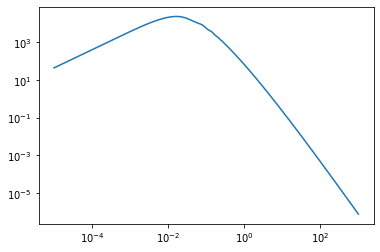

In [3]:
klin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[1]

# plin[1300:1330] += 100
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [4]:
n=32
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv()

(32, 32, 32)
32768 65 32768
Total run time 4.755898714065552


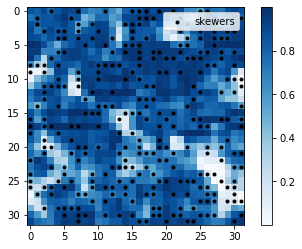

In [5]:
n_los = 300
mock_lya = lya_survey(uni,10,10,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

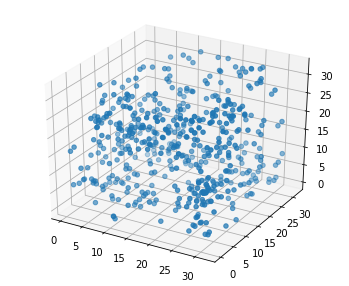

In [6]:
from mpl_toolkits.mplot3d import Axes3D
a = 8
mock_gal = gal_survey(uni,a*a) #inverse number density
mock_gal.select_galaxies() #selects galaxies

loc = mock_gal.samples_n #invidual Galaxy locations
fig=figure(figsize=(6,5))
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(loc[:,0],loc[:,1],loc[:,2])

### Example copied from TARDIS.

In [8]:
tf.reset_default_graph()
lya=mock_lya
gal=mock_gal

xx = tf.placeholder(tf.float32, shape=(1, n, n, n)) #Starting Point
linear = tf.compat.v1.get_variable('linmesh', shape=(1, n, n, n),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linear.assign(xx, name='initlin_op')

starting_point = np.random.randn(1,n,n,n)

num_gal=gal.num_gal
yy_gal = tf.placeholder(tf.float32, [1, num_gal, 2]) #galaxy locations
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux

Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

def smoothing(field,Rsm,kmesh,nc):
    """ smoothing field in fourier space
    """
    
    Rsmsq = tf.multiply(Rsm, Rsm)
    smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))

    #data = tf.squeeze(data)
    datak = tfpm.r2c3d(field, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)
    return dataf

def reduce_sum_det(x):
    #deterministic reduce sum
    v = tf.reshape(x, [1, -1])
    return tf.reshape(tf.matmul(v, tf.ones_like(v), transpose_b=True), [])
sum_op = reduce_sum_det

def likelihood_fn_specz(inputs, data):
    """ Evaluates the data chi-squared function
    """
    #Clipping very high values which end up dominating the likelihood
    data_clip = K.clip(data,-4,6)
    inputs_clip = K.clip(inputs,-4,6)
    residual = tf.subtract(inputs, data)
    #weighted by number count in bin for poisson errors
    values = -tf.multiply(tf.multiply(inputs_clip,data_clip),data_clip)

    return values

def likelihood_fn_lya(inputs, data, inverse_covar):
    """ Evaluates the data chi-squared function through Fast PM
    """
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))

    return values

specz_likelihood = likelihood_fn_specz
evolved_field,evolved_state = uni.pm(linear)

In [9]:
zz = tf.Variable(gal.samples_n[:,2].reshape(1,-1,1).astype(np.float32), name="redshift", trainable=False) #Bias

galaxy_positions = tf.concat([yy_gal,zz],axis=2)

data = flowpm.cic_paint(tf.zeros_like(linear), galaxy_positions)

Rsm = tf.multiply(Rs, 1)

kvec = fftk((n,n,n), symmetric=False)
kmesh = sum((kk)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

data_sm = smoothing(data,Rsm,kmesh,n)

likelihood_specz = specz_likelihood(evolved_field,data_sm)

gal_bias=[1.0,0.0]
bias_lya = tf.Variable([0.226,1.5], name="variables", trainable=False) #Bias
bias_galaxy = tf.Variable(gal_bias, name="variables", trainable=False) #Bias
state_l = flowpm.lpt_init(linear, a0=0.000001)
ic_den = flowpm.cic_paint(tf.zeros_like(linear),state_l[0])

RSD_gal,RSD_tau = uni.RSD(evolved_field,evolved_state,bias_galaxy,bias_lya,ic_den)      

evolved_field_FGPA = K.exp(-1.0*RSD_tau)#fgpa(self.evolved_field,bias_lya)
evolved_field_FGPA_sm = smoothing(evolved_field_FGPA,Rsm,kmesh,n)
flux_val = flowpm.cic_readout(evolved_field_FGPA_sm,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))

likelihood = likelihood_fn_lya(flux_val,yy_lya,lya.inverse_covar)
likelihood_lya = sum_op(likelihood)

post1 = sum_op(likelihood_specz)
post2 = sum_op(likelihood_lya)
specz_fac = 0
lya_fac = 1.0

lineark = flowpm.utils.r2c3d(linear, norm=n**3)
priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior_1 = sum_op(tf.multiply(priormesh, 1./pkmesh**2))#*100000*8**3*2*2
prior_total = prior_1

logposterior = (post1/10.0*specz_fac + post2*10.0*lya_fac) + sum_op(prior_total)

pk_it = pk(tf.squeeze(linear,0),shape = linear.shape[1:], boxsize= np.array([n,n,n]),kmin=0.001,dk=uni.dk)

gtol=1e-5/512

sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(initlin_op, {xx:starting_point})
anneal_steps = [3,2,1,0]
maxiter = [3,3,3,3]

time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(logposterior, var_list=[linear], method='L-BFGS-B',options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})
    z = opt.minimize(sess, {yy_gal:gal.samples_n[:,:2].reshape(1,gal.num_gal,2),yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_linear, recon_evolved, recon_RSD_tau,recon_flux,recon_gal,recon_pk,recon_evolved_state= sess.run(
            [linear, evolved_field, RSD_tau,RSD_gal,flux_val,pk_it,evolved_state],
          {xx:starting_point, yy_gal:gal.samples_n[:,:2].reshape(1,gal.num_gal,2), yy_lya:lya.vals_observed,Rs:[1]})

G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


(32, 32, 32)
32768 65 32768
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 126933.273438
  Number of iterations: 3
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 121578.007812
  Number of iterations: 3
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 110809.203125
  Number of iterations: 3
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 87299.164062
  Number of iterations: 3
  Number of functions evaluations: 6
Total run time 28.327073


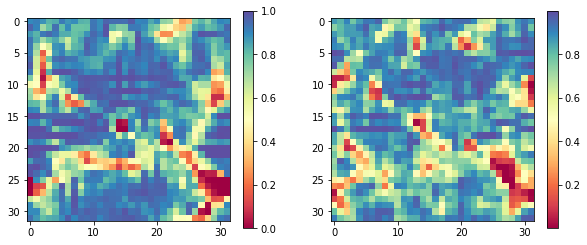

In [10]:
i=0
fig = figure(figsize=(10,4))
fig.add_subplot(121)
imshow(ndimage.gaussian_filter(exp(-recon_RSD_tau[0,:,:,i]),0.1),cmap="Spectral")
colorbar()
fig.add_subplot(122)
imshow(ndimage.gaussian_filter(np.exp(-1*uni.final_tau_RSD[0,:,:,i]),0.1),cmap="Spectral")
colorbar()

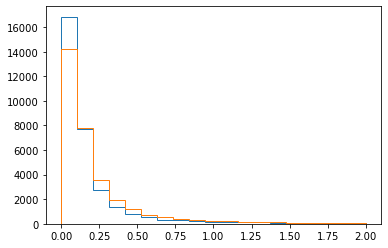

In [11]:
bins=linspace(0,2,20)
hist(recon_RSD_tau.flatten(),bins,histtype='step')
hist(uni.final_tau_RSD.flatten(),bins,histtype='step')
show()

### Wiener filter (without gravitational evolution)

Let N be the noise covariance, $S_m$ be the smoothing operator, s is the reconstructed flux field, d is the data, and R is the mapping from flux field to data space. The quantity to be optimized:
$$\chi^2 = (S_m(s) - s)^2 + (R(s) - d)^T N^{-1} (R(s)-d)$$


In [12]:
def loss(inputs, data, inverse_covar):
    
    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

tf.reset_default_graph()
lya=mock_lya

xx = tf.placeholder(tf.float32, shape=(1, n, n, n)) #Starting Point

initial=tf.Variable(zeros(shape=(1,n,n,n)),dtype='float32',trainable=True)

RSD_tau = tf.multiply(initial,1)

Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')
sum_op = reduce_sum_det

Rsm = tf.multiply(Rs, 1)
kvec = fftk((n,n,n), symmetric=False)
# kmesh = __builtin__.sum((kk)**2 for kk in kvec)**0.5
kmesh = __builtin__.sum((np.array(kvec,dtype=object))**2)**0.5
pkmesh = ipklin(kmesh)

flux = K.exp(-RSD_tau)
flux_s = smoothing(flux,Rsm,kmesh,n)
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
# flux_val = flowpm.cic_readout(flux,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
#The chi^2 we want to minimize


In [13]:
obj_fun = loss(flux_val,yy_lya,lya.inverse_covar)+2*sum_op(tf.square(tf.subtract(flux_s,flux)))
sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())
# sess.run(RSD_tau)
gtol=1e-5/512
anneal_steps = [3,2,1.5,1,0.7]
maxiter = [50,50,50,60,30]
# anneal_steps = [1,0.7]
# maxiter = [200,200]
# vals_clip = np.clip(lya.vals_observed,None,1)
time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[initial], method='L-BFGS-B',options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})
    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau2,recon_flux2 = sess.run([RSD_tau,flux_val],{yy_lya:lya.vals_observed,Rs:[0]})

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 12961.138672
  Number of iterations: 10
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 12569.774414
  Number of iterations: 11
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 12127.259766
  Number of iterations: 28
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 11139.283203
  Number of iterations: 60
  Number of functions evaluations: 62
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 9650.342773
  Nu

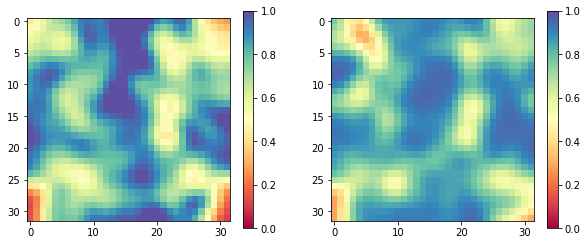

In [15]:
i=5
sigma=1.4
fig = figure(figsize=(10,4))
fig.add_subplot(121)
imshow(ndimage.gaussian_filter(exp(-recon_RSD_tau2[0,:,:,i]),sigma),vmin=0,vmax=1,cmap="Spectral")
colorbar()
fig.add_subplot(122)
imshow(ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0,:,:,i]),sigma),vmin=0,vmax=1,cmap="Spectral")
colorbar()
show()

In [16]:
d_los=n/sqrt(n_los)
d_los

1.8475208614068022

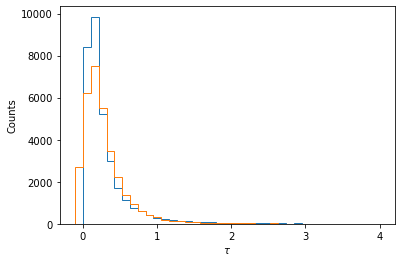

In [17]:
bins=linspace(-0.1,4,40)
hist(ndimage.gaussian_filter(uni.final_tau_RSD,1).flatten(),bins,histtype='step')
hist(ndimage.gaussian_filter(recon_RSD_tau2,1).flatten(),bins,histtype='step')

ylabel('Counts')
xlabel(r'$\tau$')
show()

In [18]:
def pdf_plot(y,bins,**kwargs):
    fig=figure()
    ax = fig.add_subplot(111)
    out=ax.hist(y,bins=bins)
    close(fig)
    s = size(y)
    y = out[0]
    n = len(y)
    x = linspace((out[1][0]+out[1][1])/2,(out[1][-1]+out[1][-2])/2,n)
    y=y/s
    plot(x,y,**kwargs)

G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


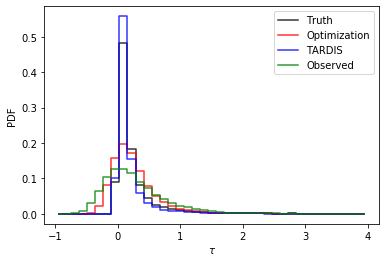

In [19]:
bins=linspace(-1,4,40)
pdf_plot(uni.final_tau_RSD.flatten(),bins,alpha=0.8,color='black',drawstyle='steps-mid',label='Truth')
pdf_plot(recon_RSD_tau2.flatten(),bins,alpha=0.8,drawstyle='steps-mid',label='Optimization',color='red')
pdf_plot(recon_RSD_tau.flatten(),bins,alpha=0.8,drawstyle='steps-mid',label='TARDIS',color='blue')


pdf_plot(-log(lya.vals_observed).flatten(),bins,alpha=0.8,drawstyle='steps-mid',label='Observed',color='green')
legend()
ylabel('PDF')
xlabel(r'$\tau$')
savefig('asd.png')
show()

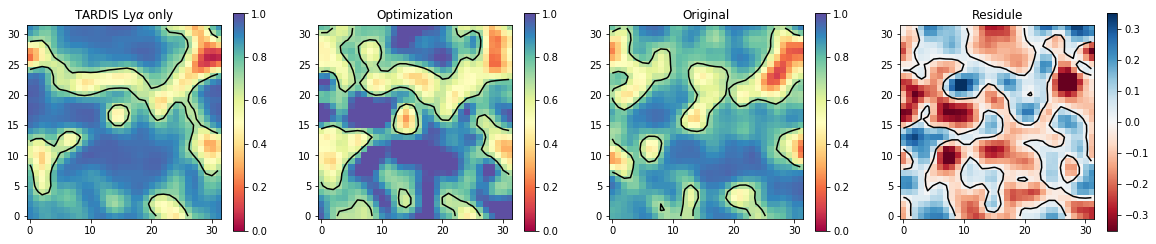

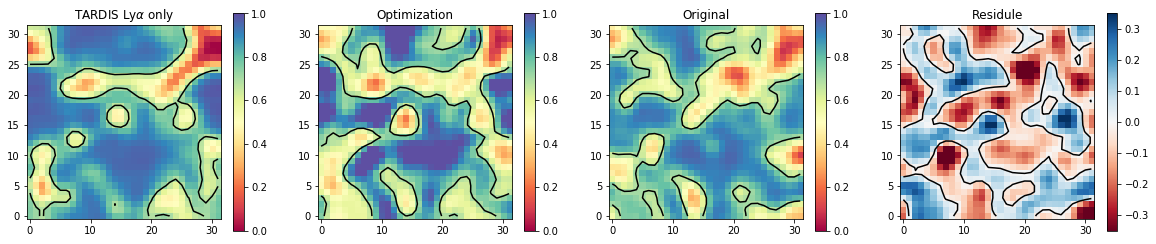

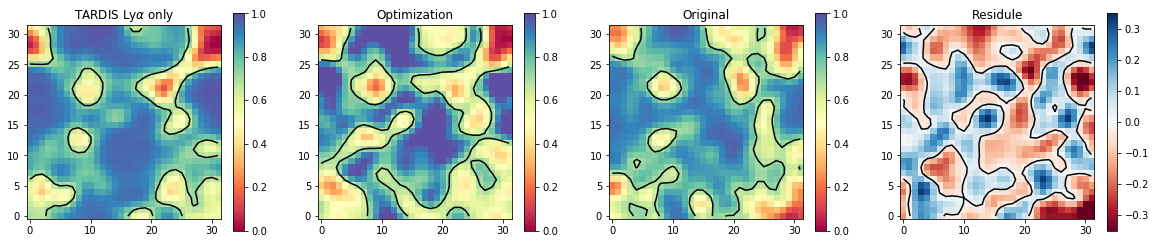

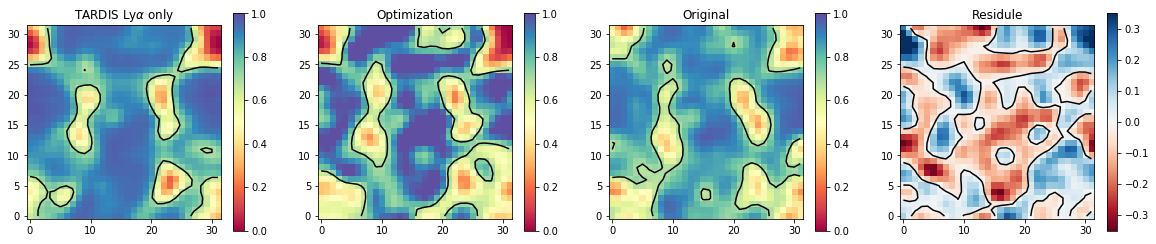

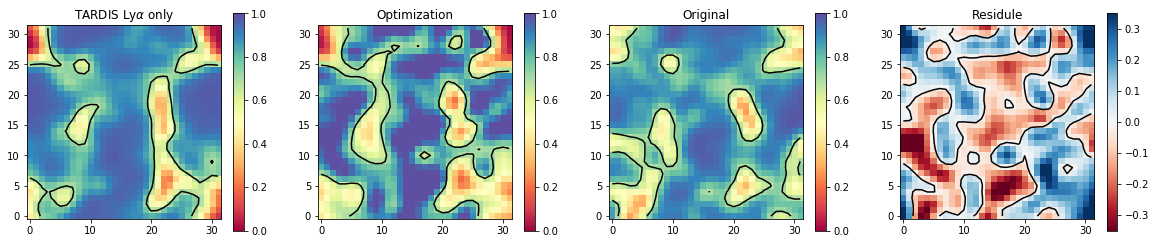

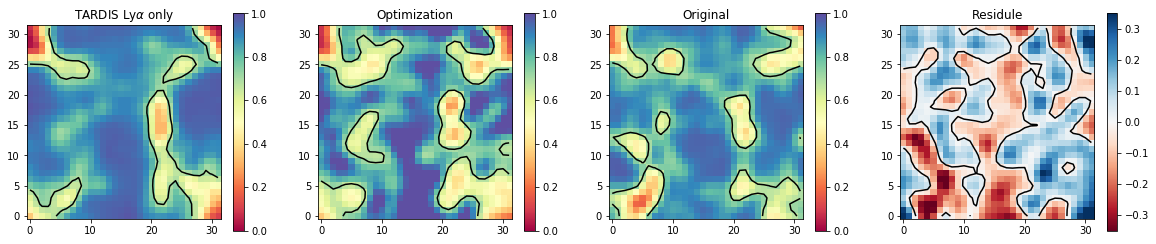

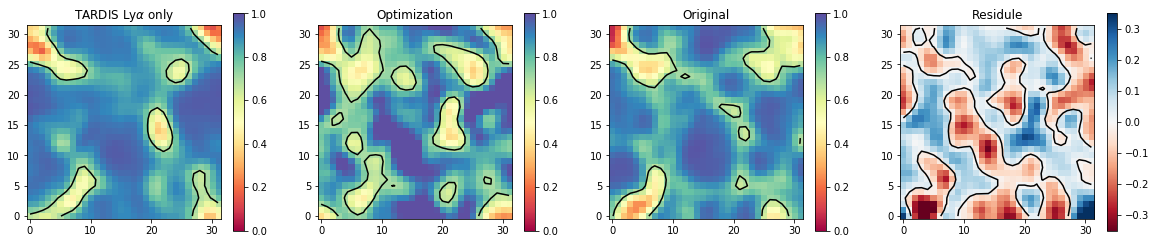

In [139]:
i=5
sigma=1
plot_list = {'vmin':0,'vmax':1,'cmap':"Spectral",'origin':'lower'}
for i in range(n-25):
    fig = figure(figsize=(20,4))
    fig.add_subplot(141)
    ga1 = ndimage.gaussian_filter(exp(-recon_RSD_tau[0,:,:,i]),sigma)
    imshow(ga1,**plot_list)
    colorbar()
    contour(ga1,levels=[0.7],colors='black')
    title(r'TARDIS Ly$\alpha$ only')

    fig.add_subplot(142)
    ga2 = ndimage.gaussian_filter(exp(-recon_RSD_tau2[0,:,:,i]),sigma)
    imshow(ga2,**plot_list)
    colorbar()
    contour(ga2,levels=[0.7],colors='black')
    title('Optimization')

    fig.add_subplot(143)
    ga3=ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0,:,:,i]),sigma)
    imshow(ga3,**plot_list)
    colorbar()
    contour(ga3,levels=[0.7],colors='black')
    title('Original')

    fig.add_subplot(144)
    res = ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0,:,:,i]),sigma)-ndimage.gaussian_filter(exp(-recon_RSD_tau2[0,:,:,i]),sigma)
    imshow(res,cmap="RdBu",origin='lower',vmin=-0.35,vmax=0.35)
    colorbar()
    con = contour(res,levels=[0],colors='black')
    title('Residule')
show()


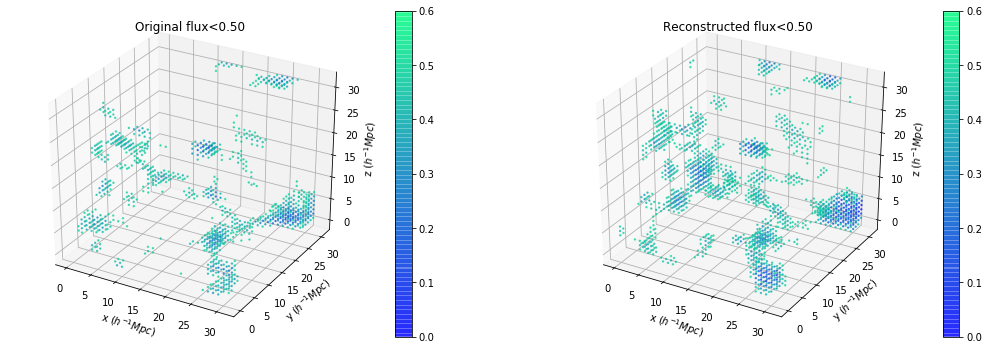

In [23]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.6)
plot_list = {'norm':norm,'alpha':0.6,'s':2,'cmap':'winter','marker':'o'}
flux_max = 0.5

fig = plt.figure(figsize=(18, 6))

true=ndimage.gaussian_filter(np.exp(-1*uni.final_tau_RSD[0]),1)
idx1=where(true<flux_max)
ax1 = fig.add_subplot(121, projection='3d')
sc1=ax1.scatter(idx1[0],idx1[1],idx1[2],c=true[idx1].flatten(),**plot_list)
colorbar(sc1,ax=ax1)
ax1.set_xlabel(r'x ($h^{-1}Mpc$)')
ax1.set_ylabel(r'y ($h^{-1}Mpc$)')
ax1.set_zlabel(r'z ($h^{-1}Mpc$)')
ax1.set_title('Original flux<%.2f'%flux_max)

flux_recon = exp(-recon_RSD_tau2[0])
flux_recon_sm = ndimage.gaussian_filter(flux_recon,1)
idx2=where(flux_recon_sm<flux_max)
ax2 = fig.add_subplot(122, projection='3d')
sc2=ax2.scatter(idx2[0],idx2[1],idx2[2],c=flux_recon_sm[idx2].flatten(),**plot_list)
colorbar(sc2,ax=ax2)
ax2.set_xlabel(r'x ($h^{-1}Mpc$)')
ax2.set_ylabel(r'y ($h^{-1}Mpc$)')
ax2.set_zlabel(r'z ($h^{-1}Mpc$)')
ax2.set_title('Reconstructed flux<%.2f'%flux_max)
savefig('123.pdf',bbox_inches='tight')
show()

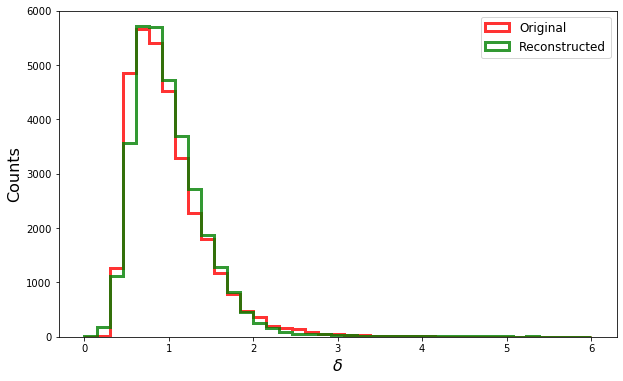

In [151]:
recon_RSD_tau2_clip = np.clip(recon_RSD_tau2,0,None)
density_recon = (recon_RSD_tau2_clip[0]/0.226)**(1/1.5)
density_true = (uni.final_tau_RSD[0]/0.226)**(1/1.5)
sigma=d_los
figure(figsize=(10,6))
bins = np.linspace(0,6,40)

plt.hist(ndimage.gaussian_filter(density_true,sigma).flatten(),bins=bins,alpha=0.8,color="red",histtype='step',linewidth=3,label='Original')
plt.hist(ndimage.gaussian_filter(density_recon,sigma).flatten(),bins=bins,alpha=0.8,color='green',histtype='step',linewidth=3,label='Reconstructed')
legend(fontsize=12)
xlabel(r'$\delta$',fontsize=16)
ylabel('Counts',fontsize=16)
savefig('counts.png')
show()

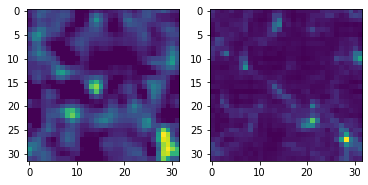

In [25]:
i=1
subplot(121)
imshow(density_recon[:,:,i])
subplot(122)
imshow(density_true[:,:,i])

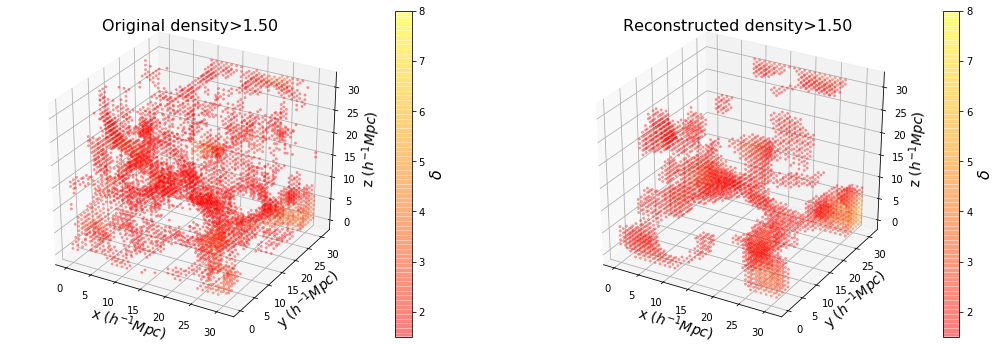

In [155]:
density_min = 1.5
sigma = d_los
norm = matplotlib.colors.Normalize(vmin=density_min, vmax=8)
plot_list = {'norm':norm,'alpha':0.3,'s':4,'cmap':'autumn','marker':'o'}


fig = plt.figure(figsize=(18, 6))

true_sm=ndimage.gaussian_filter(density_true,sigma)
idx1=where(density_true>density_min)
ax1 = fig.add_subplot(121, projection='3d')
sc1=ax1.scatter(idx1[0],idx1[1],idx1[2],c=true_sm[idx1].flatten(),**plot_list)
cb = colorbar(sc1,ax=ax1)
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

cb.set_label(r'$\delta$',fontdict=font)
ax1.set_xlabel(r'x ($h^{-1}Mpc$)',fontsize=14)
ax1.set_ylabel(r'y ($h^{-1}Mpc$)',fontsize=14)
ax1.set_zlabel(r'z ($h^{-1}Mpc$)',fontsize=14)
ax1.set_title('Original density>%.2f'%density_min,fontsize=16)

density_recon_sm = ndimage.gaussian_filter(density_recon,sigma)
idx2=where(density_recon_sm>density_min)
ax2 = fig.add_subplot(122, projection='3d')
sc2=ax2.scatter(idx2[0],idx2[1],idx2[2],c=density_recon_sm[idx2].flatten(),**plot_list)
cb = colorbar(sc2,ax=ax2,label=r'$\delta$')
cb.set_label(r'$\delta$',fontdict=font)

ax2.set_xlabel(r'x ($h^{-1}Mpc$)',fontsize=14)
ax2.set_ylabel(r'y ($h^{-1}Mpc$)',fontsize=14)
ax2.set_zlabel(r'z ($h^{-1}Mpc$)',fontsize=14)
ax2.set_title('Reconstructed density>%.2f'%density_min,fontsize=16)
savefig('123.png',bbox_inches='tight')
show()

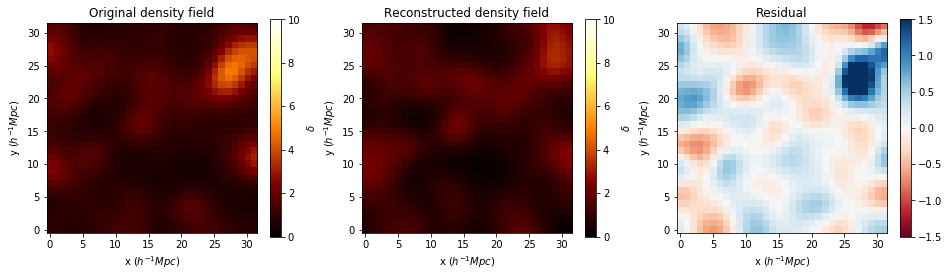

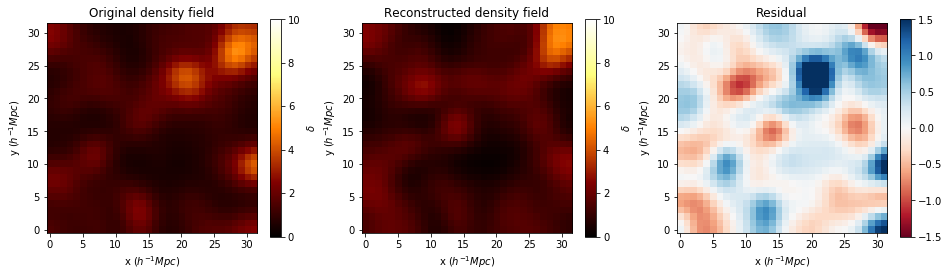

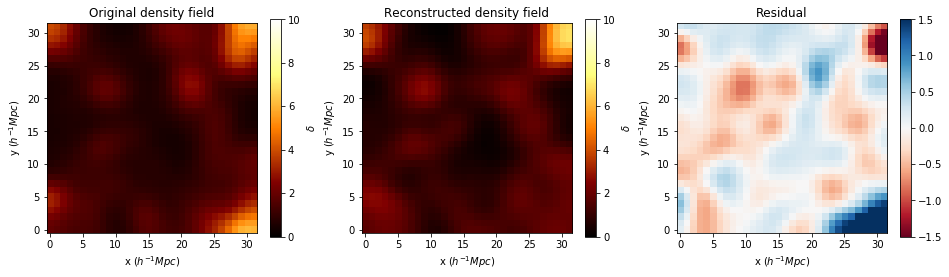

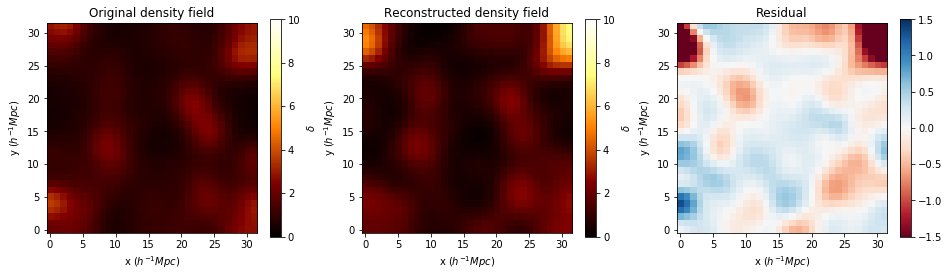

In [142]:
sigma=d_los
plot_list = {'vmin':0,'vmax':10,'cmap':'afmhot','origin':'lower'}
for i in range(n-28):
    fig = figure(figsize=(16,4))

    fig.add_subplot(131)
    ga2 = ndimage.gaussian_filter(density_true[:,:,i],sigma)
    imshow(ga2,**plot_list)
    colorbar(label=r'$\delta$')
    title('Original density field')
    xlabel(r'x ($h^{-1}Mpc$)')
    ylabel(r'y ($h^{-1}Mpc$)')

    fig.add_subplot(132)
    ga3=ndimage.gaussian_filter(density_recon[:,:,i],sigma)
    imshow(ga3,**plot_list)
    colorbar(label=r'$\delta$')
    title('Reconstructed density field')
    xlabel(r'x ($h^{-1}Mpc$)')
    ylabel(r'y ($h^{-1}Mpc$)')
    
    fig.add_subplot(133)
    res = ndimage.gaussian_filter(density_true[:,:,i],sigma)-ndimage.gaussian_filter(density_recon[:,:,i],sigma)
    imshow(res,cmap="RdBu",origin='lower',vmin=-1.5,vmax=1.5)
    colorbar()

    title('Residual')
    xlabel(r'x ($h^{-1}Mpc$)')
    ylabel(r'y ($h^{-1}Mpc$)')
    savefig('density%d.svg'%i,bbox_inches='tight',transparent=True)

    show()


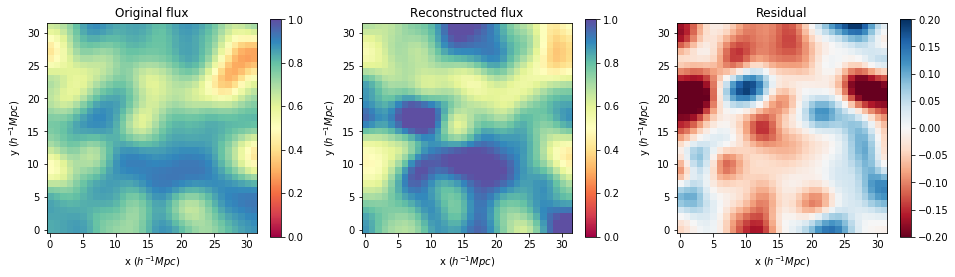

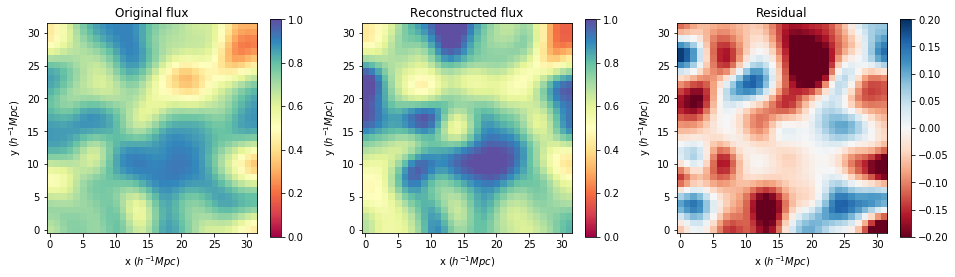

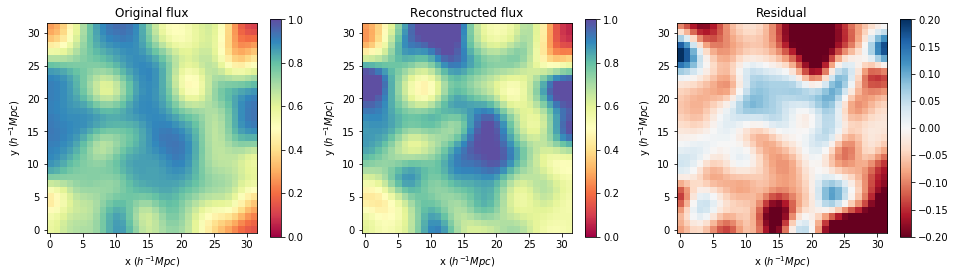

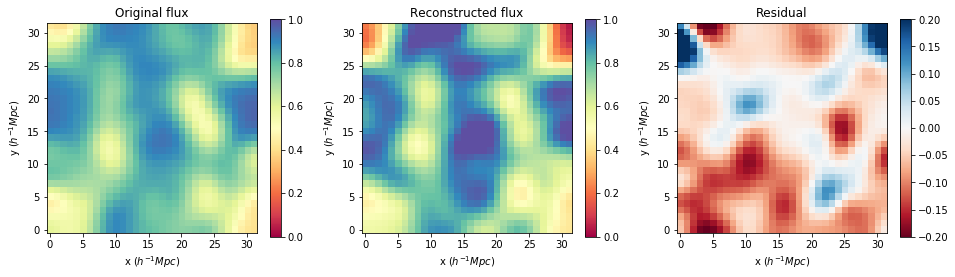

In [143]:
sigma=d_los
plot_list = {'vmin':0,'vmax':1,'cmap':'Spectral','origin':'lower'}
for i in range(n-28):
    fig = figure(figsize=(16,4))

    fig.add_subplot(131)
    ga2 = ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0,:,:,i]),sigma)
    imshow(ga2,**plot_list)
    colorbar()
    title('Original flux')
    xlabel(r'x ($h^{-1}Mpc$)')
    ylabel(r'y ($h^{-1}Mpc$)')

    fig.add_subplot(132)
    ga3=ndimage.gaussian_filter(exp(-recon_RSD_tau2[0,:,:,i]),sigma)
    imshow(ga3,**plot_list)
    colorbar()
    title('Reconstructed flux')
    xlabel(r'x ($h^{-1}Mpc$)')
    ylabel(r'y ($h^{-1}Mpc$)')
    
    fig.add_subplot(133)
    res = ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0,:,:,i]),sigma)-ndimage.gaussian_filter(exp(-recon_RSD_tau[0,:,:,i]),sigma)
    imshow(res,cmap="RdBu",origin='lower',vmin=-0.2,vmax=0.2)
    colorbar()

    title('Residual')
    xlabel(r'x ($h^{-1}Mpc$)')
    ylabel(r'y ($h^{-1}Mpc$)')
    savefig('flux%d.svg'%i,bbox_inches='tight',transparent=True)

    show()


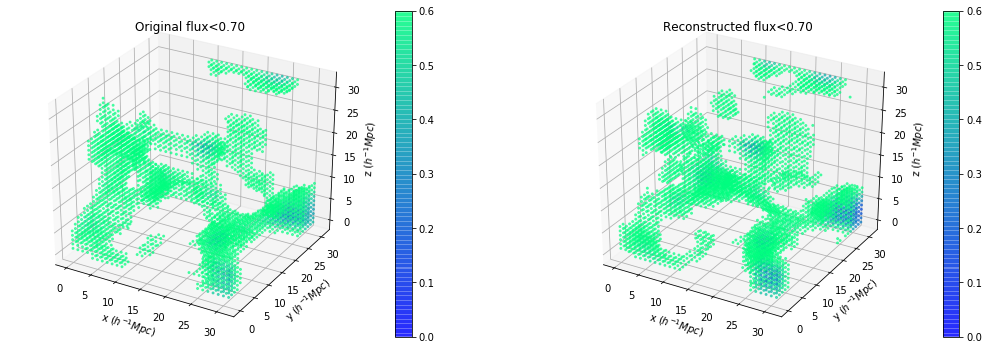

In [147]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.6)
plot_list = {'norm':norm,'alpha':0.6,'s':4,'cmap':'winter','marker':'o'}
flux_max = 0.7

fig = plt.figure(figsize=(18, 6))

true=ndimage.gaussian_filter(np.exp(-1*uni.final_tau_RSD[0]),d_los)
idx1=where(true<flux_max)
ax1 = fig.add_subplot(121, projection='3d')
sc1=ax1.scatter(idx1[0],idx1[1],idx1[2],c=true[idx1].flatten(),**plot_list)
colorbar(sc1,ax=ax1)
ax1.set_xlabel(r'x ($h^{-1}Mpc$)')
ax1.set_ylabel(r'y ($h^{-1}Mpc$)')
ax1.set_zlabel(r'z ($h^{-1}Mpc$)')
ax1.set_title('Original flux<%.2f'%flux_max)

flux_recon = exp(-recon_RSD_tau2[0])
flux_recon_sm = ndimage.gaussian_filter(flux_recon,d_los)
idx2=where(flux_recon_sm<flux_max)
ax2 = fig.add_subplot(122, projection='3d')
sc2=ax2.scatter(idx2[0],idx2[1],idx2[2],c=flux_recon_sm[idx2].flatten(),**plot_list)
colorbar(sc2,ax=ax2)
ax2.set_xlabel(r'x ($h^{-1}Mpc$)')
ax2.set_ylabel(r'y ($h^{-1}Mpc$)')
ax2.set_zlabel(r'z ($h^{-1}Mpc$)')
ax2.set_title('Reconstructed flux<%.2f'%flux_max)
savefig('123.pdf')
show()

In [30]:
data_coords = mock_lya.skewers_fin
d = mock_lya.vals_observed.reshape(-1,n)

map_x,map_y,map_z = meshgrid(arange(0,n),arange(0,n),arange(0,n))
m = np.zeros(shape=(n,n,n))
map_coords = np.vstack(list(map(np.ravel, [map_x,map_y,map_z]))).T

sigma2 = np.cov(d.flatten())

d = mock_lya.vals_observed.reshape(-1,n)
d_los = n/np.sqrt(n_los)
L_para = d_los
L_prep = d_los

m_1 = map_coords[:,0]
d_1 = data_coords[:,0]
m_2 = map_coords[:,1]
d_2 = data_coords[:,1]
m_3 = map_coords[:,2]
d_3 = data_coords[:,2]

sigma2 = np.cov(d.flatten())
L_para = n/np.sqrt(n_los)
L_prep = n/np.sqrt(n_los)

In [31]:
start_time=time.time()
m_1_matrix = np.tile(m_1,(len(d_1),1)).T
d_1_matrix = np.tile(d_1,(len(m_1),1))
m_2_matrix = np.tile(m_2,(len(d_2),1)).T
d_2_matrix = np.tile(d_2,(len(m_2),1))

r_prep = (m_1_matrix-d_1_matrix)**2+(m_2_matrix-d_2_matrix)**2
del m_1_matrix,d_1_matrix,m_2_matrix,d_2_matrix

m_3_matrix = np.tile(m_3,(len(d_3),1)).T
d_3_matrix = np.tile(d_3,(len(m_3),1))

r_para = (m_3_matrix-d_3_matrix)**2
del m_3_matrix,d_3_matrix

C_MD = sigma2*np.exp(-r_para/L_para**2)*np.exp(-r_prep/L_para**2)
end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:50.018049 s


In [32]:
start_time=time.time()

d_1_matrix2 = np.tile(d_1,(len(d_1),1))
d_1_matrix1 = d_1_matrix2.T

d_2_matrix2 = np.tile(d_2,(len(d_2),1))
d_2_matrix1 = d_2_matrix2.T

d_3_matrix2 = np.tile(d_3,(len(d_3),1))
d_3_matrix1 = d_3_matrix2.T

r_prep = (d_1_matrix1-d_1_matrix2)**2+(d_2_matrix1-d_2_matrix2)**2
r_para = (d_3_matrix1-d_3_matrix2)**2

C_DD = sigma2*np.exp(-r_para/L_para**2)*np.exp(-r_prep/L_para**2)

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:10.520079 s


In [33]:
noise=mock_lya.inverse_covar
N = 1/noise.values
N = diagflat(N)

In [34]:
start_time=time.time()

mat_inv = inv(C_DD+N)

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:29.830629 s


In [35]:
start_time=time.time()

kernel = np.dot(C_MD,mat_inv)

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:57.318481 s


In [36]:
start_time=time.time()

# kernel = np.dot(C_MD,mat_inv)
M = np.dot(kernel,d.flatten())
M_final=M.reshape(n,n,n)
M_final=array([M_final[:,i,:] for i in range(n)])

end_time=time.time()
print('Total run time:%f s'%(end_time-start_time))

Total run time:0.123713 s


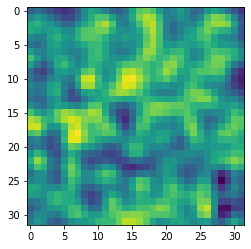

In [37]:
imshow(M_final[:,:,0])

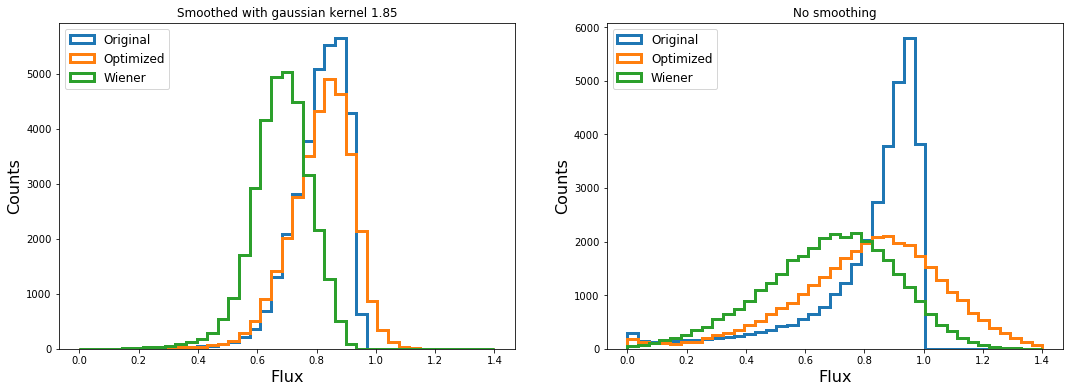

In [144]:
sigma=d_los
bins=linspace(0,1.4,40)
fig = figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1.hist(ndimage.gaussian_filter(exp(-uni.final_tau_RSD),sigma).flatten(),bins,histtype='step',label='Original',linewidth=3)
ax1.hist(ndimage.gaussian_filter(exp(-recon_RSD_tau2),sigma).flatten(),bins,histtype='step',label='Optimized',linewidth=3)
ax1.hist(ndimage.gaussian_filter(M_final,sigma).flatten(),bins,histtype='step',label='Wiener',linewidth=3)

legend(loc=2,fontsize=12)
ax1.set_ylabel('Counts',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)
ax1.set_title('Smoothed with gaussian kernel %.2f'%sigma)
ax2 = fig.add_subplot(122)

ax2.hist(exp(-uni.final_tau_RSD).flatten(),bins,histtype='step',label='Original',linewidth=3)
ax2.hist(exp(-recon_RSD_tau2).flatten(),bins,histtype='step',label='Optimized',linewidth=3)
ax2.hist(M_final.flatten(),bins,histtype='step',label='Wiener',linewidth=3)

legend(loc=2,fontsize=12)
ax2.set_ylabel('Counts',fontsize=16)
ax2.set_xlabel('Flux',fontsize=16)
ax2.set_title('No smoothing')

show()

In [40]:
def pdf_plot(y,bins,**kwargs):
    fig=figure()
    ax = fig.add_subplot(111)
    out=ax.hist(y,bins=bins)
    close(fig)
    s = size(y)
    y = out[0]
    n = len(y)
    x = linspace((out[1][0]+out[1][1])/2,(out[1][-1]+out[1][-2])/2,n)
    y=y/s
    plot(x,y,**kwargs)

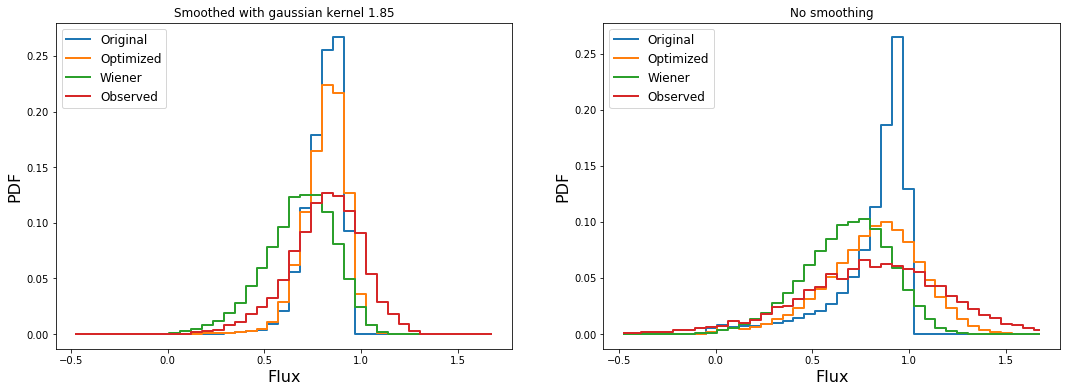

In [156]:
sigma=d_los
bins=linspace(-0.5,1.7,40)
figure(figsize=(18,6))
subplot(121)
pdf_plot(ndimage.gaussian_filter(exp(-uni.final_tau_RSD),sigma).flatten(),bins,drawstyle='steps-mid',label='Original',linewidth=2)
pdf_plot(ndimage.gaussian_filter(exp(-recon_RSD_tau2),sigma).flatten(),bins,label='Optimized',drawstyle='steps-mid',linewidth=2)
pdf_plot(ndimage.gaussian_filter(M_final.flatten(),sigma).flatten(),bins,label='Wiener',drawstyle='steps-mid',linewidth=2)
pdf_plot(ndimage.gaussian_filter(lya.vals_observed.flatten(),sigma).flatten(),bins,label='Observed',drawstyle='steps-mid',linewidth=2)

legend(loc=2,fontsize=12)
ylabel('PDF',fontsize=16)
xlabel('Flux',fontsize=16)
title('Smoothed with gaussian kernel %.2f'%sigma)
subplot(122)
pdf_plot(exp(-uni.final_tau_RSD).flatten(),bins,drawstyle='steps-mid',label='Original',linewidth=2)
pdf_plot(exp(-recon_RSD_tau2).flatten(),bins,label='Optimized',drawstyle='steps-mid',linewidth=2)
pdf_plot(M_final.flatten(),bins,label='Wiener',drawstyle='steps-mid',linewidth=2)
pdf_plot(lya.vals_observed.flatten(),bins,label='Observed',drawstyle='steps-mid',linewidth=2)

legend(loc=2,fontsize=12)
ylabel('PDF',fontsize=16)
xlabel('Flux',fontsize=16)
title('No smoothing')
show()


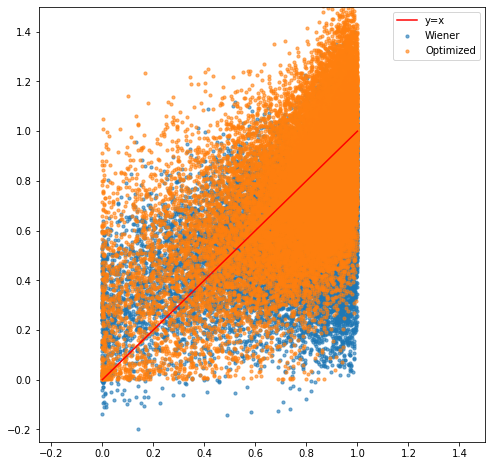

In [95]:
figure(figsize=(8,8))
scatter(exp(-uni.final_tau_RSD).flatten(),M_final.flatten().flatten(),alpha=0.6,s=10,label='Wiener')
scatter(exp(-uni.final_tau_RSD).flatten(),exp(-recon_RSD_tau2).flatten(),alpha=0.6,s=10,label='Optimized')
plot([0,1],[0,1],'r',label='y=x')
xlim(-0.25,1.5)
ylim(-0.25,1.5)
legend()

In [169]:
flux_rec = M_final
deltay = flux_rec/flux_rec.mean()-1
flux_orig = exp(-uni.final_tau_RSD)
deltax = flux_orig/flux_orig.mean()-1
x4 = ndimage.gaussian_filter(deltax,sigma).flatten()
y4 = ndimage.gaussian_filter(deltay,sigma).flatten()
xy4 = np.vstack([x4,y4])
z4 = gaussian_kde(xy4)(xy4)

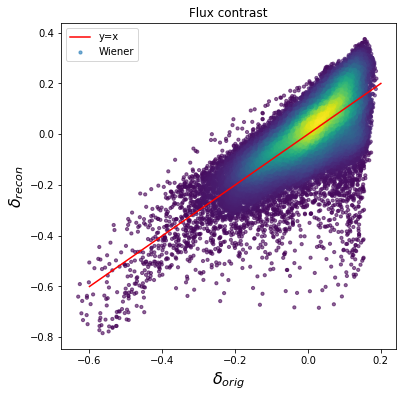

In [177]:
figure(figsize=(6,6))
scatter(x4,y4,c=z4,alpha=0.6,s=10,label='Wiener')
plot([-0.6,0.2],[-0.6,0.2],'r',label='y=x')
legend()
xlabel(r'$\delta_{orig}$',fontsize=16)
ylabel(r'$\delta_{recon}$',fontsize=16)
title('Flux contrast')
show()

In [157]:
sigma=d_los
x = ndimage.gaussian_filter(exp(-uni.final_tau_RSD),sigma).flatten()
y = ndimage.gaussian_filter(exp(-recon_RSD_tau2),sigma).flatten()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

In [158]:
y2 = ndimage.gaussian_filter(M_final,sigma).flatten()
xy2 = np.vstack([x,y2])
z2 = gaussian_kde(xy2)(xy2)

In [159]:
y3 = ndimage.gaussian_filter(exp(-recon_RSD_tau),sigma).flatten()
xy3 = np.vstack([x,y3])
z3 = gaussian_kde(xy3)(xy3)

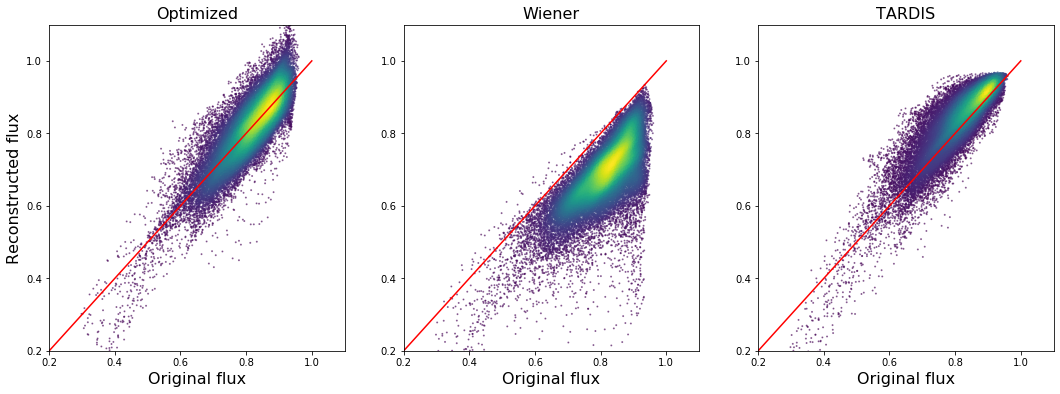

In [176]:
fig = figure(figsize=(18,6))
ax1 = fig.add_subplot(131)
ax1.scatter(x,y,c=z,alpha=0.5,s=1)
ax1.plot([0,1],[0,1],'r')
ax1.set_xlim(0.2,1.1)
ax1.set_ylim(0.2,1.1)
ax1.set_title('Optimized',fontsize=16)
ax1.set_xlabel('Original flux',fontsize=16)
ax1.set_ylabel('Reconstructed flux',fontsize=16)

ax2 = fig.add_subplot(132)
ax2.scatter(x,y2,c=z2,alpha=0.5,s=1)
ax2.plot([0,1],[0,1],'r')
ax2.set_xlim(0.2,1.1)
ax2.set_ylim(0.2,1.1)
ax2.set_title('Wiener',fontsize=16)
ax2.set_xlabel('Original flux',fontsize=16)

ax3 = fig.add_subplot(133)
ax3.scatter(x,y3,c=z3,alpha=0.5,s=1)
ax3.plot([0,1],[0,1],'r')
ax3.set_title('TARDIS',fontsize=16)
ax3.set_xlabel('Original flux',fontsize=16)
ax3.set_xlim(0.2,1.1)
ax3.set_ylim(0.2,1.1)
show()
# ax.invert_yaxis()
# ax.invert_xaxis()